# generator model

/tmp/ipykernel_82850/200131688.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(model_path, map_location=device))


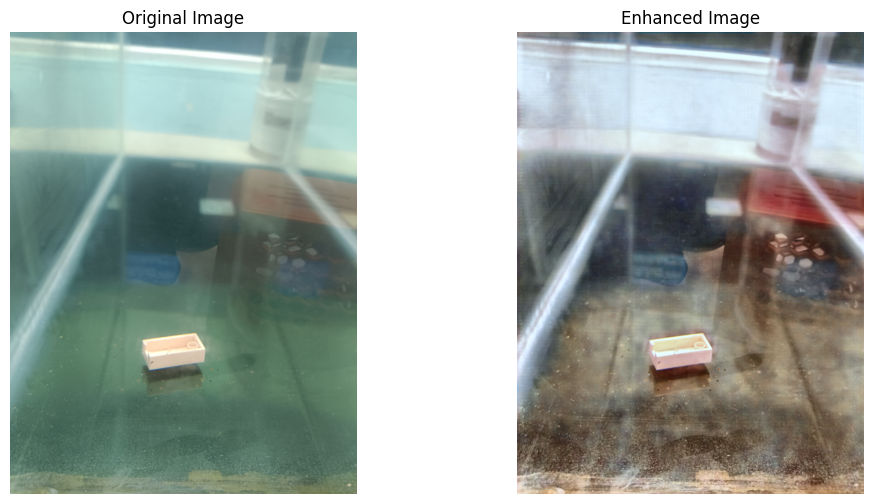

reflection removed image saved as 'reflection_removed.jpg'


In [2]:


import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image, ImageEnhance
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F
# Define UNetDown and UNetUp classes (same as provided)
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, bn=True):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if bn: layers.append(nn.BatchNorm2d(out_size, momentum=0.8))
        layers.append(nn.LeakyReLU(0.2))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size):
        super(UNetUp, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_size, momentum=0.8),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, skip_input):
        x = self.model(x)

        # Ensure spatial size matches skip_input
        if x.size(2) != skip_input.size(2) or x.size(3) != skip_input.size(3):
            x = F.interpolate(x, size=(skip_input.size(2), skip_input.size(3)), mode='bilinear', align_corners=True)

        x = torch.cat((x, skip_input), 1)  # Concatenate along channel dim
        return x

# Define Generator
class GeneratorFunieGAN(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorFunieGAN, self).__init__()
        self.down1 = UNetDown(in_channels, 32, bn=False)
        self.down2 = UNetDown(32, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 256)
        self.down5 = UNetDown(256, 256, bn=False)
        self.up1 = UNetUp(256, 256)
        self.up2 = UNetUp(512, 256)
        self.up3 = UNetUp(512, 128)
        self.up4 = UNetUp(256, 32)
        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(64, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        u1 = self.up1(d5, d4)
        u2 = self.up2(u1, d3)
        u3 = self.up3(u2, d2)
        u4 = self.up4(u3, d1)
        return self.final(u4)

# Load trained generator model
def load_generator(model_path, device):
    generator = GeneratorFunieGAN().to(device)
    generator.load_state_dict(torch.load(model_path, map_location=device))
    generator.eval()
    return generator

# Preprocess input image
def preprocess_image(image_path, device):
    image = Image.open(image_path).convert("RGB")
    original_size = image.size  # Save original size (width, height)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    image = transform(image).unsqueeze(0).to(device)
    return image, original_size



# Convert output tensor to image
def tensor_to_image(tensor, original_size):
    tensor = tensor.squeeze(0).detach().cpu()
    tensor = (tensor + 1) / 2  # Rescale to [0, 1]
    image = transforms.ToPILImage()(tensor)
    
    # Resize back to original size
    image = image.resize(original_size, Image.BICUBIC)
    return image

# Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)
def apply_clahe(image):
    image_cv = np.array(image)
    lab = cv2.cvtColor(image_cv, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    limg = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return Image.fromarray(enhanced_img)

# Apply White Balance Correction
def white_balance(image):
    image_cv = np.array(image)
    result = cv2.cvtColor(image_cv, cv2.COLOR_RGB2LAB)
    avg_a = np.mean(result[:, :, 1])
    avg_b = np.mean(result[:, :, 2])
    
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    
    result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
    return Image.fromarray(result)

# Apply Bilateral Filtering for Denoising
def denoise_image(image):
    image_cv = np.array(image)
    denoised = cv2.bilateralFilter(image_cv, d=9, sigmaColor=75, sigmaSpace=75)
    return Image.fromarray(denoised)

# Apply Sharpening
def sharpen_image(image):
    enhancer = ImageEnhance.Sharpness(image)
    return enhancer.enhance(2.0)

# Enhance image using generator and additional enhancements
def enhance_image(generator, image_path, device):
    input_image, original_size = preprocess_image(image_path, device)
    
    with torch.no_grad():
        output_image = generator(input_image)
    
    enhanced_image = tensor_to_image(output_image, original_size)  # Restore original size
    
    # Apply additional enhancements
    enhanced_image = apply_clahe(enhanced_image)
    enhanced_image = white_balance(enhanced_image)
    enhanced_image = denoise_image(enhanced_image)
    enhanced_image = sharpen_image(enhanced_image)
    
    return enhanced_image

# Main function
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator_path = "model/funie_generator.pth"  # Update with correct path
    image_path = "images_data/IMG_20250328_170400.jpg"  # Update with your image
    
    generator = load_generator(generator_path, device)
    enhanced_image = enhance_image(generator, image_path, device)
    
    # Display original and enhanced images
    original_image = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    ax[1].imshow(enhanced_image)
    ax[1].set_title("Enhanced Image")
    ax[1].axis("off")
    plt.show()
    
    # Save enhanced image
    enhanced_image.save("reflection_removed.jpg")
    print("reflection removed image saved as 'reflection_removed.jpg'")

if __name__ == "__main__":
    main()
 



In [3]:
#-----------------------------------------------------------------------

In [4]:
pip install torch torchvision opencv-python matplotlib timm


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [14]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)


('dog.jpg', <http.client.HTTPMessage at 0x7f2020638ce0>)

# segmentation and depth estimation model 

In [ ]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
from google.colab.patches import cv2_imshow

# Load MiDaS depth estimation model
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
midas.to("cuda" if torch.cuda.is_available() else "cpu")
midas.eval()

# Load MiDaS transforms
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform

# Load YOLOv8-seg for segmentation
yolo_model = YOLO("yolov8m-seg.pt")

# Load input image
filename = "/content/statue.jpg"
image = cv2.imread(filename)
if image is None:
    raise ValueError("Image not found or unable to load.")

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply YOLOv8 segmentation with confidence threshold
results = yolo_model(image_rgb, conf=0.25)  # Lower confidence threshold

if len(results[0].masks) == 0:
    raise ValueError("No object detected by YOLO segmentation.")

# Extract largest mask
masks = results[0].masks.data.cpu().numpy()
segmentation_mask = np.max(masks, axis=0)  # Use max mask (for overlapping detections)
segmentation_mask = (segmentation_mask * 255).astype(np.uint8)
segmentation_mask = cv2.resize(segmentation_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

# Apply mask to extract object
segmented_object = cv2.bitwise_and(image_rgb, image_rgb, mask=segmentation_mask)

# Convert segmented object for MiDaS
input_batch = transform(segmented_object).to("cuda" if torch.cuda.is_available() else "cpu")

# Predict depth map using MiDaS
with torch.no_grad():
    depth_prediction = midas(input_batch)
    depth_prediction = torch.nn.functional.interpolate(
        depth_prediction.unsqueeze(1),
        size=image.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth_map = depth_prediction.cpu().numpy()

# Normalize depth map
depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
depth_map = (depth_map * 255).astype(np.uint8)

# Apply segmentation mask to depth map
depth_map_filtered = depth_map * (segmentation_mask > 0)

# Apply color map for visualization
depth_map_colored = cv2.applyColorMap(depth_map_filtered, cv2.COLORMAP_JET)

# Detect contours in the depth map for height estimation
gray = cv2.cvtColor(depth_map_colored, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    # Get the largest contour (assumed to be the object)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Use minAreaRect to get a better bounding box
    rect = cv2.minAreaRect(largest_contour)
    (x, y), (w, h), angle = rect

    # **🔹 Relative Depth-to-Height Conversion**
    known_distance_cm = 300  # Assume known camera-object distance
    reference_depth = np.median(depth_map_filtered[segmentation_mask > 0])  # Median object depth

    if reference_depth > 0:
        scale_factor = known_distance_cm / reference_depth
        estimated_height_cm = h * scale_factor
    else:
        estimated_height_cm = 0  # Fallback if depth is unreliable

    # Draw bounding box
    box = cv2.boxPoints(rect)
    box = np.int32(box)
    cv2.drawContours(depth_map_colored, [box], 0, (0, 255, 0), 2)
    
    # Add text annotation
    cv2.putText(depth_map_colored, f"Height: {estimated_height_cm:.2f} cm",
                (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Display final depth estimation
cv2_imshow(depth_map_colored)


# test code 

In [ ]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
from google.colab.patches import cv2_imshow

# Load MiDaS depth estimation model
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Large")
midas.to("cuda" if torch.cuda.is_available() else "cpu")
midas.eval()

# Load MiDaS transforms
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
transform = midas_transforms.dpt_transform

# Load YOLOv8-seg for segmentation
yolo_model = YOLO("yolov8x-seg.pt")  # Using 'x' version for better detection

# Load input image
filename = "/content/bottle.jpg"  # Change this to your image path
image = cv2.imread(filename)
if image is None:
    raise ValueError("Image not found or unable to load.")

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply YOLOv8 segmentation with lower confidence threshold
results = yolo_model(image_rgb, conf=0.1)  

# Debug: Print detection results
print("YOLO Detection Details:", results[0].boxes)  # Bounding boxes
print("YOLO Segmentation Masks:", results[0].masks)  # Masks

# Ensure detections exist
if results[0].masks is None or results[0].masks.data is None:
    raise ValueError("No object detected by YOLO segmentation.")

# Process detected masks
masks = results[0].masks.data.cpu().numpy()
if masks.shape[0] == 0:
    raise ValueError("No object mask found in the detections.")

# Extract largest mask
segmentation_mask = np.max(masks, axis=0)  
segmentation_mask = (segmentation_mask * 255).astype(np.uint8)
segmentation_mask = cv2.resize(segmentation_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

# Apply mask to extract object
segmented_object = cv2.bitwise_and(image_rgb, image_rgb, mask=segmentation_mask)

# Convert segmented object for MiDaS
input_batch = transform(segmented_object).to("cuda" if torch.cuda.is_available() else "cpu")

# Predict depth map using MiDaS
with torch.no_grad():
    depth_prediction = midas(input_batch)
    depth_prediction = torch.nn.functional.interpolate(
        depth_prediction.unsqueeze(1),
        size=image.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth_map = depth_prediction.cpu().numpy()

# Normalize depth map
depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
depth_map = (depth_map * 255).astype(np.uint8)

# Apply segmentation mask to depth map
depth_map_filtered = depth_map * (segmentation_mask > 0)

# Apply color map for visualization
depth_map_colored = cv2.applyColorMap(depth_map_filtered, cv2.COLORMAP_JET)

# **🔹 Detect contours for height estimation**
gray = cv2.cvtColor(depth_map_colored, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if contours:
    # Get the largest contour (assumed to be the object)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Use minAreaRect to get a better bounding box
    rect = cv2.minAreaRect(largest_contour)
    (x, y), (w, h), angle = rect

    # **🔹 Relative Depth-to-Height Conversion**
    known_distance_cm = 5  # Adjusted for small objects
    reference_depth = np.percentile(depth_map_filtered[segmentation_mask > 0], 80)  # More stable depth reference


    if reference_depth > 0:
        scale_factor = known_distance_cm / reference_depth
        estimated_height_cm = h * scale_factor
    else:
        estimated_height_cm = 0  # Fallback if depth is unreliable

    # Draw bounding box
    box = cv2.boxPoints(rect)
    box = np.int32(box)
    cv2.drawContours(depth_map_colored, [box], 0, (0, 255, 0), 2)
    
    # Add text annotation
    cv2.putText(depth_map_colored, f"Height: {estimated_height_cm:.2f} cm",
                (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Display final depth estimation
cv2_imshow(depth_map_colored)
